## Import Libaries
* Pandas - for data manipulation
* Matplotlib and Plotly - for data visualization 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## Import Dengue Data
import processed DOH data for forecasting dengue cases.


In [ ]:
dengue_cases=pd.read_csv('/work/TimeSeries/DOH-Epi Dengue Data 2016-2021-20220717-131000.csv')

### Select only Dengue Cases reported in Quezon City

In [ ]:
dengue_cases=dengue_cases[dengue_cases['loc']=='QUEZON CITY']

Aggregate dengue cases by date(weekly)

In [ ]:
dengue_cases=dengue_cases.groupby(['date']).sum().drop(columns=['deaths'])

In [ ]:
dengue_cases

,cases
date,
2016-01-10,58.0
2016-01-17,81.0
2016-01-24,85.0
2016-01-31,73.0
2016-02-07,75.0
...,...
2020-12-13,39.0
2020-12-20,20.0
2020-12-27,28.0


## Import Google Trends Data
import processed google trends data for Quezon City with same timeseries dates (2016-2021)

In [ ]:
google_trends=pd.read_csv('/work/TimeSeries/Google_Trends_Data_QC.csv')

In [ ]:
google_trends=google_trends[['date','dengue + lamok']]

In [ ]:
google_trends=google_trends.set_index('date')

In [ ]:
google_trends

,dengue + lamok
date,
2016-01-10,16
2016-01-17,15
2016-01-24,12
2016-01-31,15
2016-02-07,17
...,...
2020-12-13,8
2020-12-20,7
2020-12-27,8


## Merge Dengue Cases and Google Trends data

In [ ]:
merge_qc=pd.merge(dengue_cases,google_trends,left_index=True, right_index=True)

In [ ]:
merge_qc

,cases,dengue + lamok
date,,
2016-01-10,58.0,16
2016-01-17,81.0,15
2016-01-24,85.0,12
2016-01-31,73.0,15
2016-02-07,75.0,17
...,...,...
2020-12-13,39.0,8
2020-12-20,20.0,7
2020-12-27,28.0,8


In [ ]:
fig=px.line(dengue_cases,x=dengue_cases.index,y='cases',title="Dengue Cases reported in Quezon City (2016-2021)")
fig.show()

### Check if data is stationary

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the **significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary**.


Time series are stationary if they **do not have trend or seasonal effects**. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

In [ ]:
!pip install statsmodels==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 KB 39.5 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
        
        
        
adf_test(dengue_cases['cases'])

1. ADF :  -3.846997454400208
2. P-Value :  0.002461458093812467
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression: 254
5. Critical Values :
	 1% :  -3.456360306409983
	 5% :  -2.8729872043802356
	 10% :  -2.572870232500465


## Train, Test, Split

75% of the data was used for **training**: from Jan 2016 to Oct 2019 (195 weeks)

25% of the data was used for **testing**: from Oct 2019 to Jan 2021 (64 weeks)

In [ ]:
import math
train=merge_qc[:math.ceil(merge_qc.shape[0]*0.75)]
test=merge_qc[math.ceil(merge_qc.shape[0]*0.75):]

In [ ]:
train

,cases,dengue + lamok
date,,
2016-01-10,58.0,16
2016-01-17,81.0,15
2016-01-24,85.0,12
2016-01-31,73.0,15
2016-02-07,75.0,17
...,...,...
2019-09-15,703.0,64
2019-09-22,546.0,62
2019-09-29,528.0,50


In [ ]:
test

,cases,dengue + lamok
date,,
2019-10-20,385.0,26
2019-10-27,292.0,26
2019-11-03,263.0,21
2019-11-10,242.0,24
2019-11-17,221.0,20
...,...,...
2020-12-13,39.0,8
2020-12-20,20.0,7
2020-12-27,28.0,8


## Train the model 

Train a forecast model using the ARIMA algorithm for forecasting dengue with DOH Data and Google Trends

In [ ]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(train[['cases']], exogenous=train[['dengue + lamok']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2331.826, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2122.254, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2329.863, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2168.490, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2103.367, Time=2.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2299.254, Time=0.90 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2086.111, Time=2.40 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2098.733, Time=0.92 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=2081.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  195
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood               -1025.116
Date:                             Fri, 15 Jul 2022   AIC                           2070.232
Time:                                     10:07:49   BIC                           2102.327
Sample:                                          0   HQIC                          2083.242
                                             - 195                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.6207      0.562      1.104      0.270      -0.481       1.723
dengue + lamok     0.6047      1.053      0.574      0.566      -1.460       2.669
ar.L1              1.1466      0.104     11.065      0.000       0.943       1.350
ar.L2              0.5747      0.190      3.028      0.002       0.203       0.947
ar.L3             -0.7527      0.092     -8.217      0.000      -0.932      -0.573
ma.L1             -0.4565      0.140     -3.272      0.001      -0.730      -0.183
ma.L2             -0.4613      0.139     -3.320      0.001      -0.734      -0.189
ar.S.L12          -0.6989      0.074     -9.392      0.000      -0.845      -0.553
ar.S.L24          -0.2938      0.083     -3.542      0.000      -0.456      -0.131
sigma2          3999.1609    332.953     12.011      0.000    3346.585    4651.737
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                38.02
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.52
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Results

D:\Program Files - Data Drive\Anaconda 3\envs\aedes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

<ipython-input-77-38607ca547a8>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



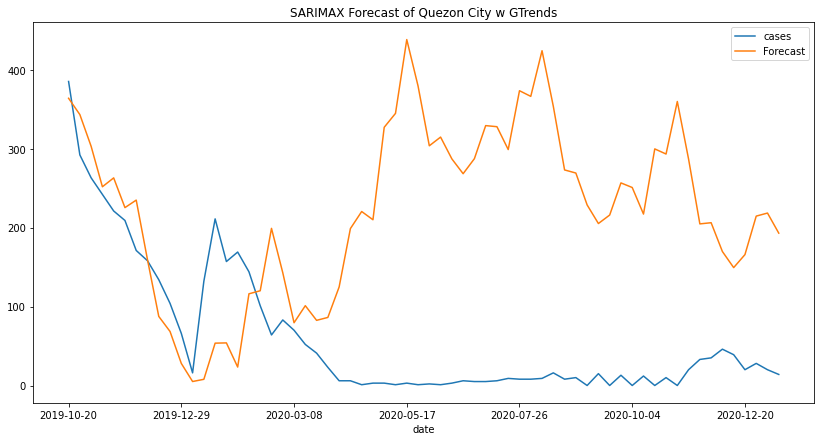

In [ ]:

fitted, confint = sxmodel.predict(n_periods=len(test),
                                  exogenous=exo,
                                  return_conf_int=True)

test['Forecast']=fitted
# index_of_fc = pd.date_range(test.index[-1], periods = n_periods, freq='MS')

# # make series for plotting purpose
# fitted_series = pd.Series(fitted, index=index_of_fc)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# # Plot
# plt.plot(test['cases'])
# plt.plot(fitted_series, color='darkgreen')
# plt.fill_between(lower_series.index, 
#                  lower_series, 
#                  upper_series, 
#                  color='k', alpha=.15)



test[["cases", "Forecast"]].plot(figsize=(14, 7))

plt.title("SARIMAX Forecast of Quezon City w GTrends")
plt.show()

## Model error metrics

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(test.cases, test.Forecast)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(test.cases, test.Forecast))

RMSE of Auto ARIMAX: 219.94514552461885

MAE of Auto ARIMAX: 183.42144339611548


In [ ]:
fitted

array([363.75363642, 343.08381004, 302.91467588, 251.69275351,
       262.91388273, 225.27507566, 234.78361099, 159.26218393,
        87.49757063,  68.41425733,  27.94680186,   5.04919058,
         7.83584067,  53.62524472,  53.95745212,  23.36757996,
       116.11866386, 119.97912997, 198.98283032, 142.83735476,
        79.48828495, 101.07069128,  82.51925918,  86.19935756,
       124.7632187 , 198.71269047, 220.33433838, 209.89694995,
       327.00124889, 344.6005442 , 438.06913955, 379.3510861 ,
       303.56897252, 314.58193207, 286.98723835, 268.21348037,
       287.2565835 , 329.11472223, 327.74595518, 298.78969804,
       373.30936809, 366.14979828, 423.96853882, 353.5679907 ,
       272.98423249, 269.06281309, 228.67227417, 205.11862705,
       215.86409996, 256.55744448, 250.74560004, 217.10542409,
       299.62639266, 293.13128516, 359.65455088, 286.66855801,
       204.66271046, 206.14485093, 169.66101474, 149.3013848 ,
       165.75883376, 214.50772306, 218.37989016, 192.94

In [ ]:
exo=test['dengue + lamok']

In [ ]:
exo=exo.reset_index()


In [ ]:
exo['date']=pd.to_datetime(exo['date'])

In [ ]:
exo=exo['dengue + lamok']

In [ ]:
exo

0     26
1     26
2     21
3     24
4     20
      ..
59     8
60     7
61     8
62    10
63    10
Name: dengue + lamok, Length: 64, dtype: int64

In [ ]:
exo=test['dengue + lamok'].to_frame()

In [ ]:
exo

,dengue + lamok
date,
2019-10-20,26
2019-10-27,26
2019-11-03,21
2019-11-10,24
2019-11-17,20
...,...
2020-12-13,8
2020-12-20,7
2020-12-27,8


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e9b552be-cac8-4d99-a00a-9c19989297ab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>